In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time


In [3]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
coordsv = []
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx}/{len(df)}")
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h = image.shape[0]
    scale = 128 / h
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))/255
    images.append(image)
    coords.append((row['ellipse_x']/ h
                #    , row['ellipse_y']/h
                   ))
    coordsv.append(row['ellipse_y']/ h)

    # coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2))



image_numbers 6584
Processing 0/6584
Processing 100/6584
Processing 200/6584
Processing 300/6584
Processing 400/6584
Processing 500/6584
Processing 600/6584
Processing 700/6584
Processing 800/6584
Processing 900/6584
Processing 1000/6584
Processing 1100/6584
Processing 1200/6584
Processing 1300/6584
Processing 1400/6584
Processing 1500/6584
Processing 1600/6584
Processing 1700/6584
Processing 1800/6584
Processing 1900/6584
Processing 2000/6584
Processing 2100/6584
Processing 2200/6584
Processing 2300/6584
Processing 2400/6584
Processing 2500/6584
Processing 2600/6584
Processing 2700/6584
Processing 2800/6584
Processing 2900/6584
Processing 3000/6584
Processing 3100/6584
Processing 3200/6584
Processing 3300/6584
Processing 3400/6584
Processing 3500/6584
Processing 3600/6584
Processing 3700/6584
Processing 3800/6584
Processing 3900/6584
Processing 4000/6584
Processing 4100/6584
Processing 4200/6584
Processing 4300/6584
Processing 4400/6584
Processing 4500/6584
Processing 4600/6584
Proces

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, coords, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)
y_test  = np.array(y_test, dtype=np.float32)

X_trainv, X_testv, y_trainv, y_testv = train_test_split(images, coordsv, test_size=0.2, random_state=42)
X_trainv = np.array(X_trainv, dtype=np.float32)
y_trainv = np.array(y_trainv, dtype=np.float32)
X_testv  = np.array(X_testv, dtype=np.float32)
y_testv  = np.array(y_testv, dtype=np.float32)
def build_model(input_shape=(128,128,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: 3 × (Conv → ReLU → MaxPool)
    x = layers.Conv2D(32, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)   # 64×64×32

    x = layers.Conv2D(64, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 32×32×64

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 16×16×128

    # Flatten and dense head
    x = layers.Flatten()(x)         # 16*16*128 = 32768
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='linear')(x)  # (x, y)

    model = models.Model(inputs, outputs, name="CoordNet")
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




Model: "CoordNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       738

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelv = build_model()
modelv.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

loss, mae = model.evaluate(X_test, y_test)

# print("Actual coords:", y_test[:100])

# find mean absolute error for the x and y coordinates



Epoch 1/50
165/165 [==============================] - 4s 19ms/step - loss: 0.1587 - mae: 0.1264 - val_loss: 0.0045 - val_mae: 0.0479
Epoch 2/50
165/165 [==============================] - 3s 15ms/step - loss: 0.0088 - mae: 0.0705 - val_loss: 0.0025 - val_mae: 0.0277
Epoch 3/50
165/165 [==============================] - 2s 14ms/step - loss: 0.0076 - mae: 0.0642 - val_loss: 0.0020 - val_mae: 0.0246
Epoch 4/50
165/165 [==============================] - 2s 13ms/step - loss: 0.0069 - mae: 0.0628 - val_loss: 0.0020 - val_mae: 0.0252
Epoch 5/50
165/165 [==============================] - 2s 11ms/step - loss: 0.0066 - mae: 0.0606 - val_loss: 0.0017 - val_mae: 0.0180
Epoch 6/50
165/165 [==============================] - 2s 11ms/step - loss: 0.0064 - mae: 0.0602 - val_loss: 0.0015 - val_mae: 0.0160
Epoch 7/50
165/165 [==============================] - 2s 11ms/step - loss: 0.0061 - mae: 0.0586 - val_loss: 0.0015 - val_mae: 0.0183
Epoch 8/50
165/165 [==============================] - 2s 11ms/step - 

In [6]:
modelv.fit(
    X_trainv, y_trainv,
    validation_data=(X_testv, y_testv),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)
lossv, maev = modelv.evaluate(X_testv, y_testv)


Epoch 1/50
165/165 [==============================] - 3s 13ms/step - loss: 0.2176 - mae: 0.1280 - val_loss: 0.0020 - val_mae: 0.0295
Epoch 2/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0086 - mae: 0.0727 - val_loss: 0.0068 - val_mae: 0.0771
Epoch 3/50
165/165 [==============================] - 2s 9ms/step - loss: 0.0062 - mae: 0.0612 - val_loss: 0.0025 - val_mae: 0.0431
Epoch 4/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0043 - mae: 0.0513 - val_loss: 0.0015 - val_mae: 0.0315
Epoch 5/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0039 - mae: 0.0486 - val_loss: 7.9263e-04 - val_mae: 0.0160
Epoch 6/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0041 - mae: 0.0501 - val_loss: 0.0015 - val_mae: 0.0313
Epoch 7/50
165/165 [==============================] - 2s 10ms/step - loss: 0.0039 - mae: 0.0491 - val_loss: 9.2234e-04 - val_mae: 0.0186
Epoch 8/50
165/165 [==============================] - 2s 10ms/

1/1 [==============================] - 0s 42ms/step
Actual: 69.79537963867188, Predicted: [70.906784]


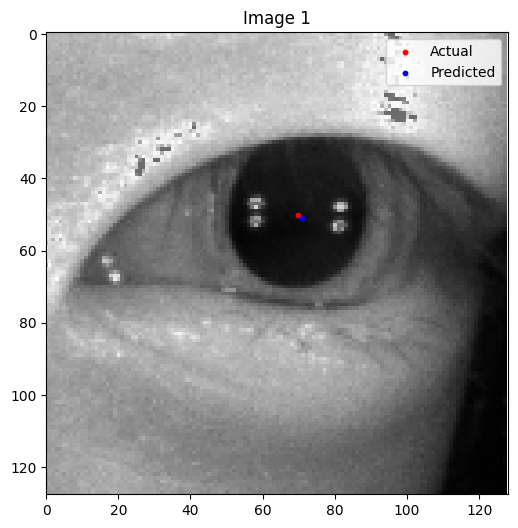

Actual: 71.69306182861328, Predicted: [71.68067]


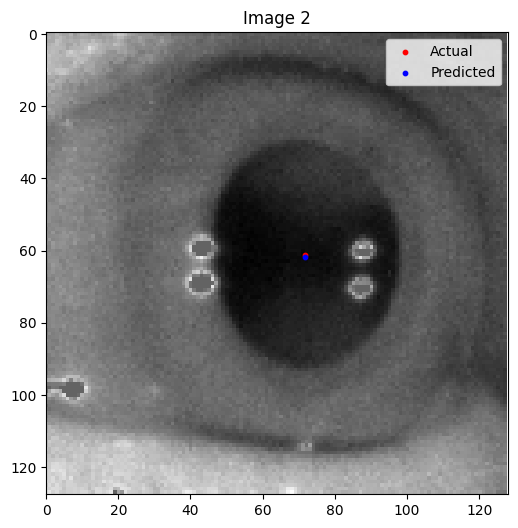

Actual: 68.70707702636719, Predicted: [67.310135]


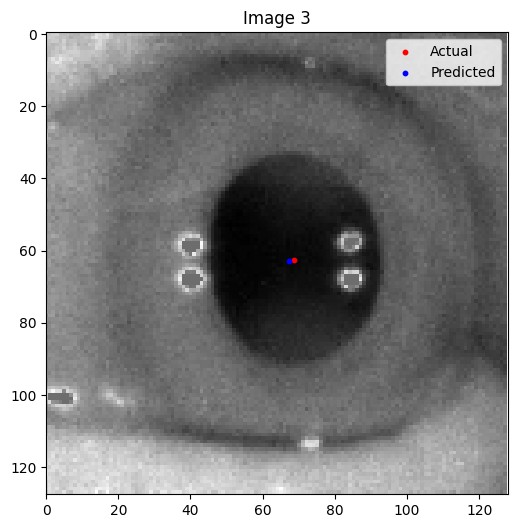

Actual: 65.43177032470703, Predicted: [72.14121]


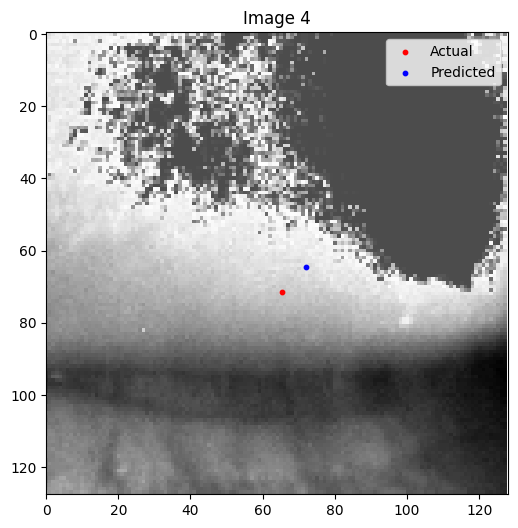

Actual: 78.2036361694336, Predicted: [79.089]


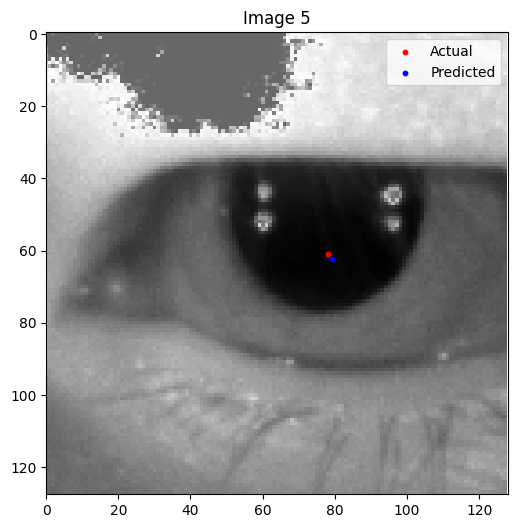

Actual: 77.85557556152344, Predicted: [80.54424]


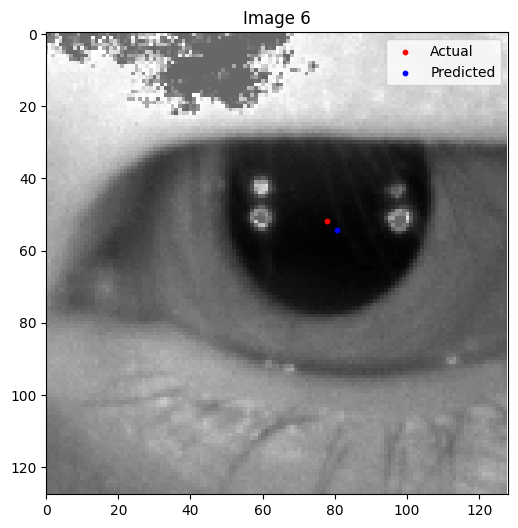

Actual: 73.39802551269531, Predicted: [72.28573]


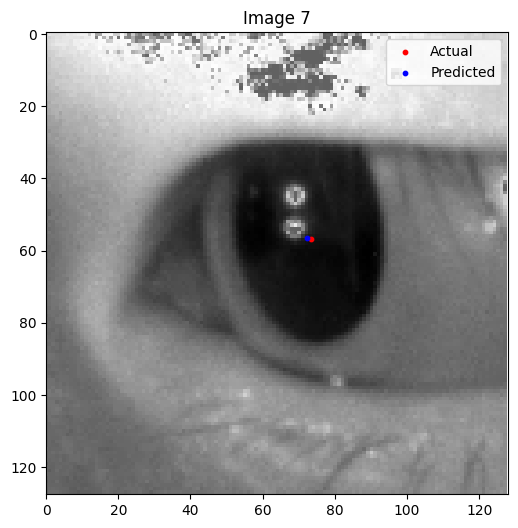

Actual: 53.441856384277344, Predicted: [54.643883]


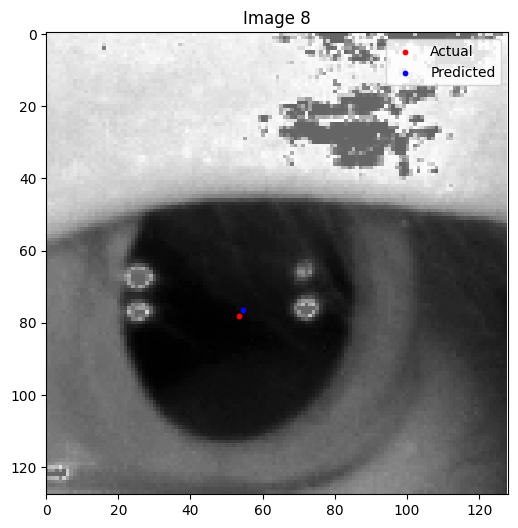

Actual: 69.00868225097656, Predicted: [69.356316]


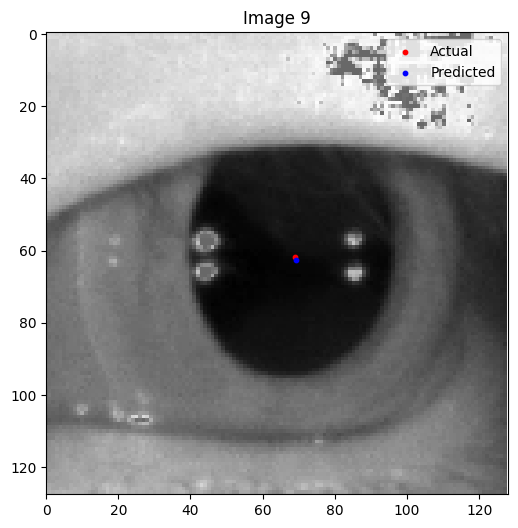

Actual: 70.6221694946289, Predicted: [70.714066]


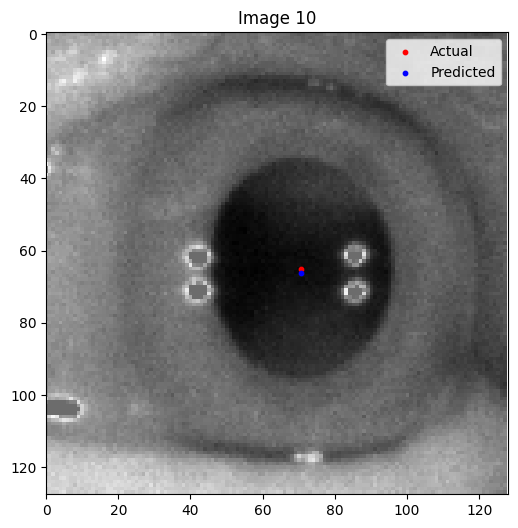

In [16]:
# plot first 5 predictions against the actual coordinates
preds = model.predict(X_test[:10])
predsv = modelv.predict(X_testv[:10])
for i in range(10):
    plt.figure(figsize=(6, 6))
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.scatter(y_test[i]*128, y_testv[i]*128, color='red', label='Actual', s=10)
    plt.scatter(preds[i]*128, predsv[i]*128, color='blue', label='Predicted', s=10)

    print(f"Actual: {y_test[i]*128}, Predicted: {preds[i]*128}")
    plt.xlim(0, 128)

    plt.title(f"Image {i+1}")
    plt.legend()
    plt.show()

In [14]:
# save CNN
model.save("eye_tracking_model.keras", include_optimizer=False)
modelv.save("eye_tracking_modelv.keras", include_optimizer=False)



In [ ]:
# go through images and show video



while True:
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Processing {idx}/{len(df)}")
        frame_num = int(row['frame_idx'])
        image_path = f"output/{frame_num}.png"
        image = cv2.imread(image_path)
        if image is None:
            continue
        # convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        h = image.shape[0]
        scale = 128 / h
        # resize the image to 128x128
        image = cv2.resize(image, (128, 128))/255
        image = np.expand_dims(image, axis=-1)  # Add channel dimension

        pred = model.predict(np.array([image]))
        predv = modelv.predict(np.array([image]))

        # draw the predicted coordinates on the image
        x, y = int(pred[0][0] * 128), int(predv[0][0] * 128)
        cv2.circle(image, (x, y), 2, (255, 0, 0), -1)

        cv2.imshow("Eye Tracking", image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

Processing 0/6584
1/1 [==============================] - 0s 44ms/step
Processing 100/6584
1/1 [==============================] - 0s 44ms/step
Processing 200/6584
1/1 [==============================] - 0s 34ms/step
Processing 300/6584
1/1 [==============================] - 0s 33ms/step
Processing 400/6584
1/1 [==============================] - 0s 33ms/step
Processing 500/6584
1/1 [==============================] - 0s 36ms/step
Processing 600/6584
1/1 [==============================] - 0s 45ms/step
Processing 700/6584
1/1 [==============================] - 0s 41ms/step
Processing 800/6584
1/1 [==============================] - 0s 30ms/step
Processing 0/6584
1/1 [==============================] - 0s 33ms/step
Processing 0/6584
1/1 [==============================] - 0s 53ms/step
Processing 0/6584
1/1 [==============================] - 0s 42ms/step
Processing 0/6584
1/1 [==============================] - 0s 30ms/step
Processing 0/6584
1/1 [==============================] - 0s 34ms/step
Proc

KeyboardInterrupt: 

: 